In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.utils import shuffle # for shuffling
import os
import cv2
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import gc



In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip

--2025-04-19 11:29:12--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   112MB/s    in 36s     

2025-04-19 11:29:47 (102 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"

Using restnet as it has  separate modules thhat can be  separately freezed also  it has good similarity to imagenet

Accuracy iis okay okay annd  no  of params is also okay okay

In [ ]:

# Define class labels for iNaturalist dataset
classesList = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]


# ResNet50 expects 224x224 images, so we resize all input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ImageNet dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


def prepare_data(data_dir, batch_size=32):
    # Load training data
    train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)

    # Create stratified train/validation split from training data
    train_indices, val_indices = [], []


    for class_idx in range(len(train_dataset.classes)):

        class_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == class_idx]

        class_train_idx, class_val_idx = train_test_split(
            class_indices,
            test_size=0.2,
            random_state=42
        )


        train_indices.extend(class_train_idx)
        val_indices.extend(class_val_idx)

    # Create data subsets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)

    # Create loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Test data - using the val folder strictly for testing only
    test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Training set size: {len(train_subset)} images")
    print(f"Validation set size: {len(val_subset)} images")
    print(f"Test set size: {len(test_dataset)} images")

    return train_loader, val_loader, test_loader

# Prepare dataloaders
train_loader, val_loader, test_loader = prepare_data('inaturalist_12K', batch_size=32)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Print class distribution
def print_class_distribution(dataloader, title):
    class_counts = {i: 0 for i in range(len(classesList))}
    for _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1

    print(f"\n{title} class distribution:")
    for i, count in class_counts.items():
        print(f"{classesList[i]}: {count} images")

# Check distribution for train and validation sets
print_class_distribution(train_loader, "Training")
print_class_distribution(val_loader, "Validation")

Training set size: 7999 images
Validation set size: 2000 images
Test set size: 2000 images
Number of training batches: 250
Number of validation batches: 63
Number of test batches: 63

Training class distribution:
Amphibia: 800 images
Animalia: 800 images
Arachnida: 800 images
Aves: 800 images
Fungi: 799 images
Insecta: 800 images
Mammalia: 800 images
Mollusca: 800 images
Plantae: 800 images
Reptilia: 800 images

Validation class distribution:
Amphibia: 200 images
Animalia: 200 images
Arachnida: 200 images
Aves: 200 images
Fungi: 200 images
Insecta: 200 images
Mammalia: 200 images
Mollusca: 200 images
Plantae: 200 images
Reptilia: 200 images


In [ ]:

!pip install wandb --quiet
import wandb
wandb.login(key="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

import matplotlib as plt

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m002 (da24m002-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


First  I am using the stratergy of freeze all layers except last.

In [ ]:
# Handle the mismatch between ImageNet's 1000 classes and iNaturalist's 10 classes
# Implementing different fine-tuning strategies

class ModelStrategy:
    def __init__(self, strategy_name='full'):
        self.strategy_name = strategy_name

    def setup_model(self):
        # Load pretrained ResNet50
        model = models.resnet50(pretrained=True)

        # Strategy 1: Freeze all layers and only train the new classification head
        if self.strategy_name == 'freeze_all_except_last':
            # Freeze all parameters in the model
            for param in model.parameters():
                param.requires_grad = False

            # Replace the final fully connected layer for 10 classes
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

        # # Strategy 2: Freeze only a certain number of early layers
        # elif self.strategy_name == 'freeze_early_layers':
        #     # Freeze the first 6 layers (conv1, bn1, and 4 layer1 blocks)
        #     layers_to_freeze = list(model.children())[:6]
        #     for layer in layers_to_freeze:
        #         for param in layer.parameters():
        #             param.requires_grad = False

        #     # Replace final FC layer
        #     num_features = model.fc.in_features
        #     model.fc = nn.Linear(num_features, 10)
        elif self.strategy_name == 'freeze_early_layers':
            # Get all layers in the model
            all_layers = list(model.children())

            # Freeze the first 20 layers instead of just 6
            # ResNet50 has a more complex structure with nested layers
            # To freeze approximately 20 layers, we need to go deeper into the model structure

            # First, freeze the initial layers (conv1, bn1, relu, maxpool)
            for layer in all_layers[:4]:
                for param in layer.parameters():
                    param.requires_grad = False

            # Then freeze layers in layer1, layer2, layer3 (these are sequential blocks that contain multiple layers each)
            for block_idx in range(4, 7):  # This targets layer1, layer2, layer3
                block = all_layers[block_idx]
                for sublayer in block:  # Each block contains multiple bottleneck/basic blocks
                    for param in sublayer.parameters():
                        param.requires_grad = False

            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

        # Strategy 3: Progressive unfreezing (initially freeze all, then gradually unfreeze)
        elif self.strategy_name == 'progressive_unfreeze':
            # Initially freeze all layers
            for param in model.parameters():
                param.requires_grad = False

            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

            # Note: We'll unfreeze progressively during training
            self.model_layers = list(model.children())

        # Strategy 4: Use lower learning rate for pretrained layers and higher for new layers
        elif self.strategy_name == 'differential_learning_rates':
            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

            # All parameters will be trainable but with different learning rates
            # We'll handle this in the optimizer setup

        # Strategy 5: Full fine-tuning (train all parameters, no freezing)
        else:
            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)
            # No freezing - all parameters will be trained

        return model.to(device)

    def get_param_groups(self, model, base_lr=0.001):
        """For differential learning rates strategy"""
        if self.strategy_name == 'differential_learning_rates':
            # Group parameters: pretrained layers get lower lr, new layers get higher lr
            pretrained_params = []
            new_params = []

            for name, param in model.named_parameters():
                if 'fc' in name:  # New layer parameters
                    new_params.append(param)
                else:  # Pretrained layer parameters
                    pretrained_params.append(param)

            param_groups = [
                {'params': pretrained_params, 'lr': base_lr * 0.1},  # Lower LR for pretrained
                {'params': new_params, 'lr': base_lr}                # Higher LR for new
            ]
            return param_groups
        else:
            return model.parameters()

    def progressive_unfreeze_step(self, model, current_epoch, total_epochs):
        """For progressive unfreezing strategy"""
        if self.strategy_name == 'progressive_unfreeze' and current_epoch > 0:
            # Calculate how many layers to unfreeze based on current epoch
            # Unfreeze from back to front (deep to shallow)
            layers_to_unfreeze = int((current_epoch / total_epochs) * len(self.model_layers))

            # Start unfreezing from the end (excluding the FC layer which is always trainable)
            for i in range(len(self.model_layers) - 1, len(self.model_layers) - 1 - layers_to_unfreeze, -1):
                if i >= 0:
                    for param in self.model_layers[i].parameters():
                        param.requires_grad = True

# Choosing one of the fine-tuning strategies
# 'freeze_all_except_last', 'freeze_early_layers', 'progressive_unfreeze', 'differential_learning_rates', 'full'

chosen_strategy = 'freeze_all_except_last'
# chosen_strategy = 'progressive_unfreeze'
model_strategy = ModelStrategy(chosen_strategy)
model = model_strategy.setup_model()

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Fixed parameters: {total_params - trainable_params:,}")
print(f"Strategy used: {chosen_strategy}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 100MB/s]


Total parameters: 23,528,522
Trainable parameters: 20,490
Fixed parameters: 23,508,032
Strategy used: freeze_all_except_last


In [ ]:
# Training and evaluation functions
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, strategy=None):
    """Train the model with the given dataloaders, criterion, and optimizer"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_acc = 0.0

    # Initialize wandb for tracking experiments
    wandb.login()
    wandb.init(project="DA6401_A2_PartA", name=f"ResNet50-{strategy.strategy_name}")
    wandb.config.update({
        "model": "ResNet50",
        "strategy": strategy.strategy_name,
        "epochs": num_epochs
    })

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']

                # For progressive unfreezing, update which layers are frozen
                if strategy.strategy_name == 'progressive_unfreeze':
                    strategy.progressive_unfreeze_step(model, epoch, num_epochs)

                    # Log how many parameters are now trainable
                    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    print(f"Epoch {epoch+1}: Trainable parameters: {trainable_params:,}")
                    wandb.log({"trainable_params": trainable_params}, step=epoch)
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - only track history in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Log metrics to wandb
            wandb.log({f"{phase}_loss": epoch_loss,
                       f"{phase}_accuracy": epoch_acc}, step=epoch)

            # Track metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Save the best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), f'best_model_{strategy.strategy_name}.pth')
                    print(f'New best validation accuracy: {best_acc:.4f}')

    wandb.finish()
    print(f'Best validation Acc: {best_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, dataloader):
    """Evaluate the model on the given dataloader"""
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {acc:.4f}')

    return acc.item()

Epoch 1/2
----------


train: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


train Loss: 1.1441 Acc: 0.6200


val: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


val Loss: 0.8251 Acc: 0.7395
New best validation accuracy: 0.7395
Epoch 2/2
----------


train: 100%|██████████| 250/250 [01:32<00:00,  2.71it/s]


train Loss: 0.8367 Acc: 0.7240


val: 100%|██████████| 63/63 [00:22<00:00,  2.78it/s]


val Loss: 0.7798 Acc: 0.7490
New best validation accuracy: 0.7490


train_accuracy,▁█
train_loss,█▁
val_accuracy,▁█
val_loss,█▁
train_accuracy,0.72397
train_loss,0.83667
val_accuracy,0.749
val_loss,0.77977


Best validation Acc: 0.7490


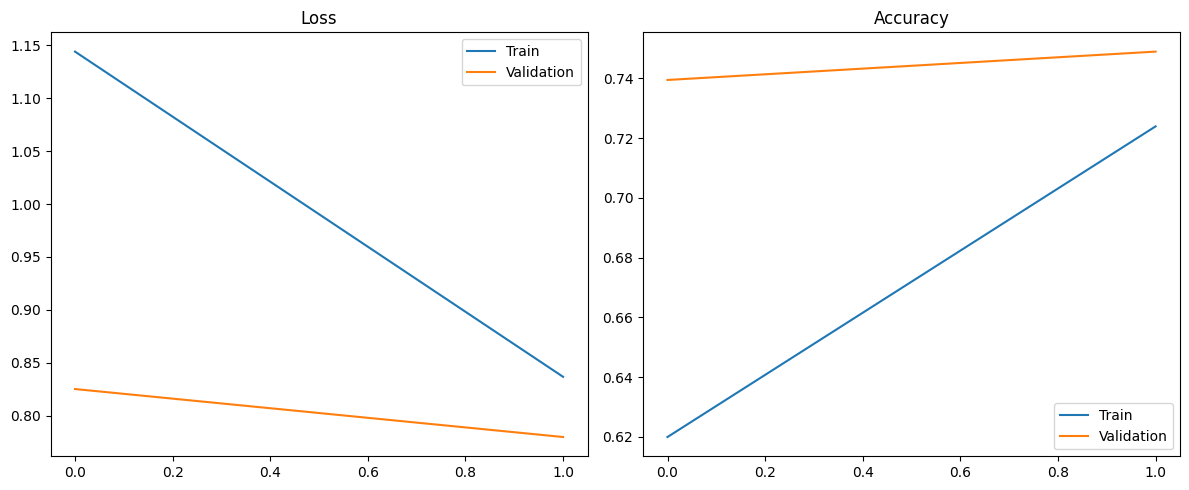


Evaluating best model on test data...


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]

Test Accuracy: 0.7415
Final test accuracy: 0.7415


In [ ]:
# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Get parameter groups (for differential learning rates if needed)
param_groups = model_strategy.get_param_groups(model, base_lr=0.001)

# Choose optimizer
if chosen_strategy == 'differential_learning_rates':
    # For this strategy,parameter groups with different learning rates has been created
    optimizer = optim.Adam(param_groups, weight_decay=0.0001)
else:
    optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0001)

# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=2,
    strategy=model_strategy
)

# plotting after training is complete
try:
    import matplotlib.pyplot as plt

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create plots: {e}")
    print("Continuing without plotting...")

# Evaluate the best model on test data
print("\nEvaluating best model on test data...")
model.load_state_dict(torch.load(f'best_model_{chosen_strategy}.pth'))
test_acc = evaluate_model(model, test_loader)
print(f"Final test accuracy: {test_acc:.4f}")

Finally using freeze initial  layers(20)

In [ ]:
# Handle the mismatch between ImageNet's 1000 classes and iNaturalist's 10 classes
# Implementing different fine-tuning strategies

class ModelStrategy:
    def __init__(self, strategy_name='full'):
        self.strategy_name = strategy_name

    def setup_model(self):
        # Load pretrained ResNet50
        model = models.resnet50(pretrained=True)

        # Strategy 1: Freeze all layers and only train the new classification head
        if self.strategy_name == 'freeze_all_except_last':
            # Freeze all parameters in the model
            for param in model.parameters():
                param.requires_grad = False

            # Replace the final fully connected layer for 10 classes
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

        # Strategy 2: Freeze only a certain number of early layers
        # elif self.strategy_name == 'freeze_early_layers':
        #     # Freeze the first 6 layers (conv1, bn1, and 4 layer1 blocks)
        #     layers_to_freeze = list(model.children())[:6]
        #     for layer in layers_to_freeze:
        #         for param in layer.parameters():
        #             param.requires_grad = False

        #     # Replace final FC layer
        #     num_features = model.fc.in_features
        #     model.fc = nn.Linear(num_features, 10)
        # Strategy 2: Freeze only a certain number of early layers
        elif self.strategy_name == 'freeze_early_layers':
            # Get all layers in the model
            all_layers = list(model.children())

            # Freeze the first 20 layers instead of just 6
            # ResNet50 has a more complex structure with nested layers
            # To freeze approximately 20 layers, we need to go deeper into the model structure

            # First, freeze the initial layers (conv1, bn1, relu, maxpool)
            for layer in all_layers[:4]:
                for param in layer.parameters():
                    param.requires_grad = False

            # Then freeze layers in layer1, layer2, layer3 (these are sequential blocks that contain multiple layers each)
            for block_idx in range(4, 7):  # This targets layer1, layer2, layer3
                block = all_layers[block_idx]
                for sublayer in block:  # Each block contains multiple bottleneck/basic blocks
                    for param in sublayer.parameters():
                        param.requires_grad = False

            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

        # Strategy 3: Progressive unfreezing (initially freeze all, then gradually unfreeze)
        elif self.strategy_name == 'progressive_unfreeze':
            # Initially freeze all layers
            for param in model.parameters():
                param.requires_grad = False

            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

            # Note: We'll unfreeze progressively during training
            self.model_layers = list(model.children())

        # Strategy 4: Use lower learning rate for pretrained layers and higher for new layers
        elif self.strategy_name == 'differential_learning_rates':
            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)

            # All parameters will be trainable but with different learning rates
            # We'll handle this in the optimizer setup

        # Strategy 5: Full fine-tuning (train all parameters, no freezing)
        else:
            # Replace final FC layer
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 10)
            # No freezing - all parameters will be trained

        return model.to(device)

    def get_param_groups(self, model, base_lr=0.001):
        """For differential learning rates strategy"""
        if self.strategy_name == 'differential_learning_rates':
            # Group parameters: pretrained layers get lower lr, new layers get higher lr
            pretrained_params = []
            new_params = []

            for name, param in model.named_parameters():
                if 'fc' in name:  # New layer parameters
                    new_params.append(param)
                else:  # Pretrained layer parameters
                    pretrained_params.append(param)

            param_groups = [
                {'params': pretrained_params, 'lr': base_lr * 0.1},  # Lower LR for pretrained
                {'params': new_params, 'lr': base_lr}                # Higher LR for new
            ]
            return param_groups
        else:
            return model.parameters()

    def progressive_unfreeze_step(self, model, current_epoch, total_epochs):
        """For progressive unfreezing strategy"""
        if self.strategy_name == 'progressive_unfreeze' and current_epoch > 0:
            # Calculate how many layers to unfreeze based on current epoch
            # Unfreeze from back to front (deep to shallow)
            layers_to_unfreeze = int((current_epoch / total_epochs) * len(self.model_layers))

            # Start unfreezing from the end (excluding the FC layer which is always trainable)
            for i in range(len(self.model_layers) - 1, len(self.model_layers) - 1 - layers_to_unfreeze, -1):
                if i >= 0:
                    for param in self.model_layers[i].parameters():
                        param.requires_grad = True

# Choosing one of the fine-tuning strategies
# 'freeze_all_except_last', 'freeze_early_layers', 'progressive_unfreeze', 'differential_learning_rates', 'full'

# chosen_strategy = 'freeze_all_except_last'
chosen_strategy = 'freeze_early_layers'
model_strategy = ModelStrategy(chosen_strategy)
model = model_strategy.setup_model()

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Fixed parameters: {total_params - trainable_params:,}")
print(f"Strategy used: {chosen_strategy}")

Total parameters: 23,528,522
Trainable parameters: 14,985,226
Fixed parameters: 8,543,296
Strategy used: freeze_early_layers


In [ ]:
# Training and evaluation functions
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, strategy=None):
    """Train the model with the given dataloaders, criterion, and optimizer"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_acc = 0.0

    # Initialize wandb for tracking experiments
    wandb.login()
    wandb.init(project="DA6401_A2_PartA", name=f"ResNet50-{strategy.strategy_name}")
    wandb.config.update({
        "model": "ResNet50",
        "strategy": strategy.strategy_name,
        "epochs": num_epochs
    })

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloaders['train']

                # For progressive unfreezing, update which layers are frozen
                if strategy.strategy_name == 'progressive_unfreeze':
                    strategy.progressive_unfreeze_step(model, epoch, num_epochs)

                    # Log how many parameters are now trainable
                    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    print(f"Epoch {epoch+1}: Trainable parameters: {trainable_params:,}")
                    wandb.log({"trainable_params": trainable_params}, step=epoch)
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - only track history in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Log metrics to wandb
            wandb.log({f"{phase}_loss": epoch_loss,
                       f"{phase}_accuracy": epoch_acc}, step=epoch)

            # Track metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Save the best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), f'best_model_{strategy.strategy_name}.pth')
                    print(f'New best validation accuracy: {best_acc:.4f}')

    wandb.finish()
    print(f'Best validation Acc: {best_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, dataloader):
    """Evaluate the model on the given dataloader"""
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {acc:.4f}')

    return acc.item()

Epoch 1/10
----------


train: 100%|██████████| 250/250 [01:27<00:00,  2.86it/s]


train Loss: 1.1954 Acc: 0.6068


val: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


val Loss: 0.9864 Acc: 0.6780
New best validation accuracy: 0.6780
Epoch 2/10
----------


train: 100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


train Loss: 0.7852 Acc: 0.7371


val: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


val Loss: 0.8612 Acc: 0.7285
New best validation accuracy: 0.7285
Epoch 3/10
----------


train: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


train Loss: 0.5579 Acc: 0.8149


val: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


val Loss: 0.9106 Acc: 0.7205
Epoch 4/10
----------


train: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s]


train Loss: 0.3911 Acc: 0.8730


val: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


val Loss: 0.9660 Acc: 0.7070
Epoch 5/10
----------


train: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


train Loss: 0.2826 Acc: 0.9056


val: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


val Loss: 1.1712 Acc: 0.7055
Epoch 6/10
----------


train: 100%|██████████| 250/250 [01:27<00:00,  2.87it/s]


train Loss: 0.2050 Acc: 0.9360


val: 100%|██████████| 63/63 [00:21<00:00,  2.98it/s]


val Loss: 1.0067 Acc: 0.7225
Epoch 7/10
----------


train: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s]


train Loss: 0.1526 Acc: 0.9491


val: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


val Loss: 1.2400 Acc: 0.6975
Epoch 8/10
----------


train: 100%|██████████| 250/250 [01:28<00:00,  2.84it/s]


train Loss: 0.1511 Acc: 0.9532


val: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


val Loss: 1.1448 Acc: 0.6990
Epoch 9/10
----------


train: 100%|██████████| 250/250 [01:26<00:00,  2.90it/s]


train Loss: 0.1164 Acc: 0.9654


val: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


val Loss: 1.1385 Acc: 0.7315
New best validation accuracy: 0.7315
Epoch 10/10
----------


train: 100%|██████████| 250/250 [01:28<00:00,  2.84it/s]


train Loss: 0.1288 Acc: 0.9619


val: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]

val Loss: 1.3122 Acc: 0.6935


train_accuracy,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁█▇▅▅▇▄▄█▃
val_loss,▃▁▂▃▆▃▇▅▅█
train_accuracy,0.96187
train_loss,0.12882
val_accuracy,0.6935
val_loss,1.31217


Best validation Acc: 0.7315


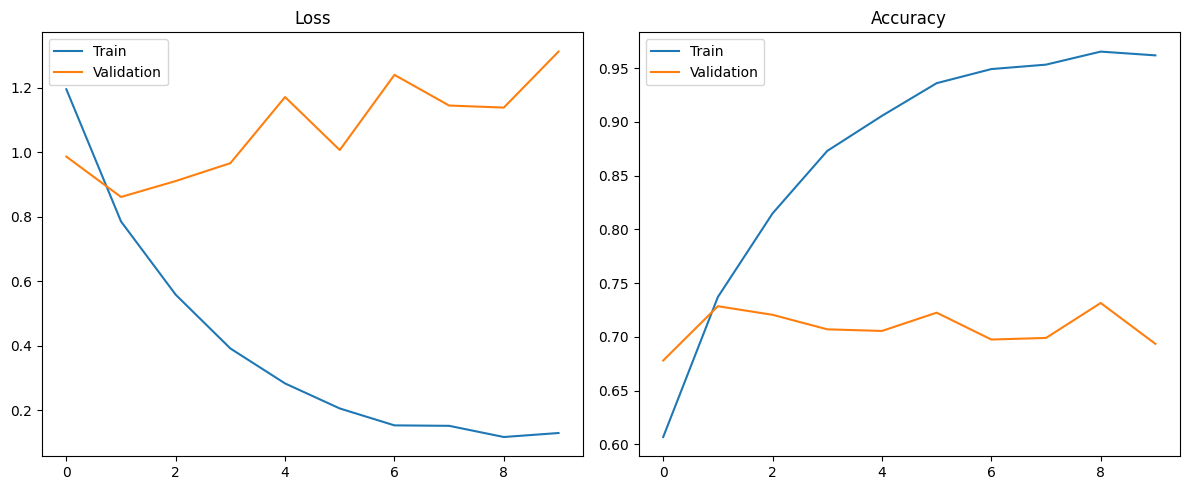


Evaluating best model on test data...


Evaluating: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]

Test Accuracy: 0.7445
Final test accuracy: 0.7445


In [ ]:
# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Get parameter groups (for differential learning rates if needed)
param_groups = model_strategy.get_param_groups(model, base_lr=0.001)

# Choose optimizer
if chosen_strategy == 'differential_learning_rates':
    # For this strategy,parameter groups with different learning rates has been created
    optimizer = optim.Adam(param_groups, weight_decay=0.0001)
else:
    optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0001)

# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    num_epochs=10,
    strategy=model_strategy
)

# plotting after training is complete
try:
    import matplotlib.pyplot as plt

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create plots: {e}")
    print("Continuing without plotting...")

# Evaluate the best model on test data
print("\nEvaluating best model on test data...")
model.load_state_dict(torch.load(f'best_model_{chosen_strategy}.pth'))
test_acc = evaluate_model(model, test_loader)
print(f"Final test accuracy: {test_acc:.4f}")

Fine-Tuning vs Training from Scratch Analysis

Training model from scratch...


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/10
----------


train: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


train Loss: 2.3119 Acc: 0.1874


val: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]


val Loss: 2.2675 Acc: 0.2110
New best validation accuracy: 0.2110
Epoch 2/10
----------


train: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


train Loss: 2.1469 Acc: 0.2308


val: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


val Loss: 2.1510 Acc: 0.2300
New best validation accuracy: 0.2300
Epoch 3/10
----------


train: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


train Loss: 2.1110 Acc: 0.2468


val: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


val Loss: 2.0824 Acc: 0.2625
New best validation accuracy: 0.2625
Epoch 4/10
----------


train: 100%|██████████| 250/250 [01:41<00:00,  2.48it/s]


train Loss: 2.0944 Acc: 0.2437


val: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


val Loss: 2.1438 Acc: 0.2335
Epoch 5/10
----------


train: 100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


train Loss: 2.0806 Acc: 0.2557


val: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


val Loss: 2.1131 Acc: 0.2550
Epoch 6/10
----------


train: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


train Loss: 2.0662 Acc: 0.2544


val: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


val Loss: 2.0373 Acc: 0.2700
New best validation accuracy: 0.2700
Epoch 7/10
----------


train: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


train Loss: 2.0476 Acc: 0.2715


val: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


val Loss: 1.9938 Acc: 0.2945
New best validation accuracy: 0.2945
Epoch 8/10
----------


train: 100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


train Loss: 2.0359 Acc: 0.2714


val: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]


val Loss: 2.0193 Acc: 0.2770
Epoch 9/10
----------


train: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]


train Loss: 2.0157 Acc: 0.2733


val: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


val Loss: 2.3152 Acc: 0.2635
Epoch 10/10
----------


train: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]


train Loss: 2.0100 Acc: 0.2773


val: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]

val Loss: 2.0052 Acc: 0.2910


train_accuracy,▁▄▆▅▆▆████
train_loss,█▄▃▃▃▂▂▂▁▁
val_accuracy,▁▃▅▃▅▆█▇▅█
val_loss,▇▄▃▄▄▂▁▂█▁
train_accuracy,0.27728
train_loss,2.00996
val_accuracy,0.291
val_loss,2.00523


Best validation Acc: 0.2945


Evaluating: 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

Test Accuracy: 0.2790

=== Comparison of Results ===
Fine-tuned model (freeze_early_layers) test accuracy: 0.7445
Model trained from scratch test accuracy: 0.2790


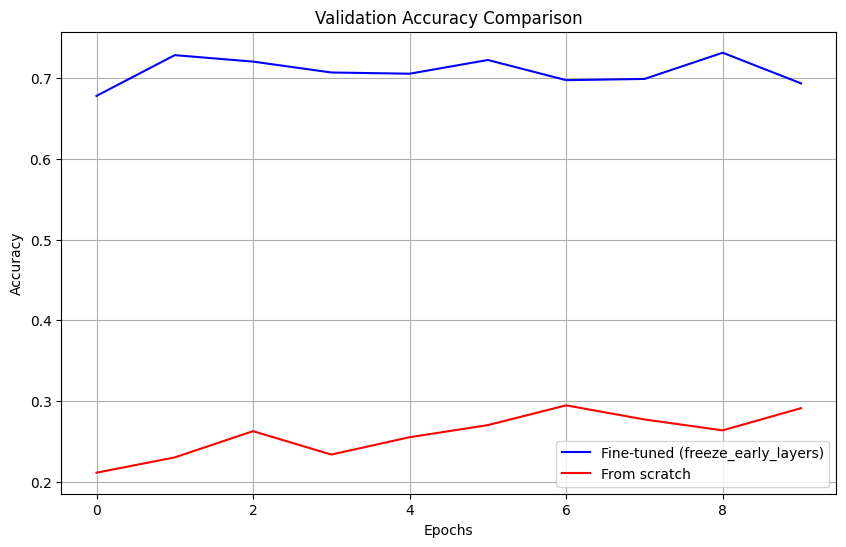

In [ ]:

# Analysis of fine-tuning strategies and comparison with training from scratch
# This cell compares the chosen fine-tuning strategy with a model trained from scratch

print("Fine-Tuning vs Training from Scratch Analysis")

# Function to create a model from scratch (similar architecture but not using ImageNet weights)
def create_scratch_model():
    # Create a ResNet50 without pretrained weights
    model = models.resnet50(pretrained=False)
    # Modify final layer for 10 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    return model.to(device)

# Initialize a model from scratch
scratch_model = create_scratch_model()

# Set up optimizer for training from scratch
scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.001, weight_decay=0.0001)

# Train the scratch model (using same training setup)
print("\nTraining model from scratch...")
wandb.init(project="DA6401_A2_PartA", name="ResNet50-from-scratch")
wandb.config.update({
    "model": "ResNet50",
    "strategy": "from-scratch",
    "epochs": 2
})

# We'll train the scratch model for the same number of epochs
scratch_model, s_train_losses, s_val_losses, s_train_accs, s_val_accs = train_model(
    scratch_model,
    dataloaders,
    criterion,
    scratch_optimizer,
    num_epochs=10,
    strategy=ModelStrategy("from-scratch")  # Just for logging
)

# Evaluate the best scratch model
scratch_model.load_state_dict(torch.load('best_model_from-scratch.pth'))
scratch_test_acc = evaluate_model(scratch_model, test_loader)

# Compare results
print("\n=== Comparison of Results ===")
print(f"Fine-tuned model ({chosen_strategy}) test accuracy: {test_acc:.4f}")
print(f"Model trained from scratch test accuracy: {scratch_test_acc:.4f}")

# Plot comparison of validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(val_accs, 'b-', label=f'Fine-tuned ({chosen_strategy})')
plt.plot(s_val_accs, 'r-', label='From scratch')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
